### 1. Package imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from utility import * # custom functions that are used throughout this script

### 2. Data read-in
Training and test data is provided in separate files, which will be merged to make preprocessing easier. The <b><font color="blue">PassengerId</font></b> will be used as index.

In [2]:
data_folder = "01_data"
train = pd.read_csv(os.path.join(os.getcwd(), data_folder, "train.csv"))
test = pd.read_csv(os.path.join(os.getcwd(), data_folder, "test.csv"))

In [3]:
train = train.set_index("PassengerId", drop=True)
test = test.set_index("PassengerId", drop=True)

In [4]:
data = combine_data(train, test)

In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TrainTest
PassengerId,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Train
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Train
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Train
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Train
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Train


### 3. Missing data

In [6]:
print("percentage of missing values:")

data.isna().sum()[data.isna().sum() > 0] / len(data)

percentage of missing values:


Survived    0.319328
Age         0.200917
Fare        0.000764
Cabin       0.774637
Embarked    0.001528
dtype: float64

<b><font color="blue">Survived</font></b> is the target variable and can be ignored.
<b><font color="blue">Cabin</font></b> has too many missing values to consider imputing.

#### Embarked
Using the most common value to impute missing values.

In [7]:
embarked_most_common = data["Embarked"].value_counts().index[0]
data["Embarked"].fillna(value=embarked_most_common, inplace=True)
print(f"Most common 'Embarked' value: {embarked_most_common}")

Most common 'Embarked' value: S


#### Fare
Since <b><font color="blue">Fare</font></b> is a numeric value, either the mean or the median value can be used to impute missing values.

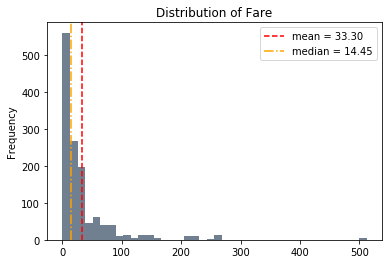

In [8]:
ax = plot_hist(data, by="Fare", bins=40)

The plot above indicates that the <b>median</b> is probably better suited, as it is less influenced by outlier values.

In [9]:
data["Fare"].fillna(value=data["Fare"].median(), inplace=True)

#### New feature: Title
Imputing the missing values of the <b><font color="blue">Age</font></b> feature is more tricky, as there are quite a few missing values (~20% of the total data set).
The <b><font color="blue">Name</font></b> feature includes titles (such as 'Mr' or 'Mrs'), which should help coming up with a better guess for <b><font color="blue">Age</font></b> than just the median/mean value across all records.
The titles will be extracted to a new feature, <b><font color="blue">Title</font></b>.

In [10]:
def get_title(x):
    titles = {"Mr.": "Mr", 
              "Mrs": "Mrs", 
              "Miss.": "Ms", 
              "Master": "Master", 
              "Ms.": "Ms",
              "Mlle.": "Ms",
              "Mme.": "Mrs"}
    for key in titles:
        if key in x:
            return titles[key]
    return "Other"

data["Title"] = data["Name"].apply(get_title)

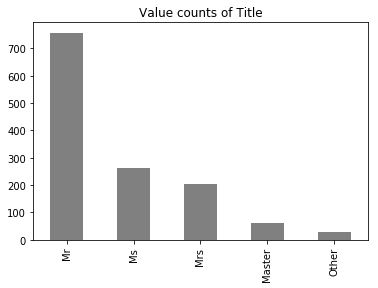

In [11]:
ax = data["Title"].value_counts().plot(kind="bar", color="grey")
ax.set_title("Value counts of Title");

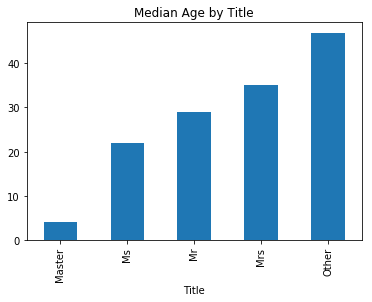

In [12]:
ax = data[["Title", "Age"]].groupby("Title").median().sort_values(by="Age").plot.bar()
ax.get_legend().remove()
ax.set_title("Median Age by Title");

As expected, there is a noticeable difference in the median ages by title.

#### Age
Using the newly created <b><font color="blue">Title</font></b> feature to impute missing <b><font color="blue">Age</font></b> values with the median age for the respective title: 

In [13]:
for title in data["Title"].unique():
    mask_title = data["Title"]==title
    mask_nan = np.isnan(data["Age"])
    median = data[mask_title]["Age"].median()
    data.loc[mask_title & mask_nan, "Age"] = median

In [14]:
data[["Embarked", "Fare", "Age"]].isna().sum()

Embarked    0
Fare        0
Age         0
dtype: int64

All missing values have been filled!

### 4. Data Exploration & Feature Engineering

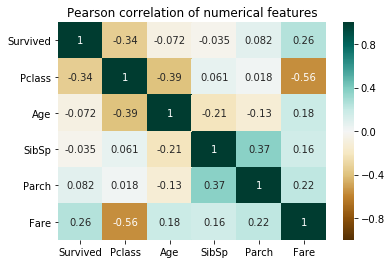

In [15]:
num_features = ["Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]
ax = sns.heatmap(data[num_features].corr(), vmin=-1, vmax=1, cmap="BrBG", annot=True)
ax.set_title("Pearson correlation of numerical features");

#### Pclass

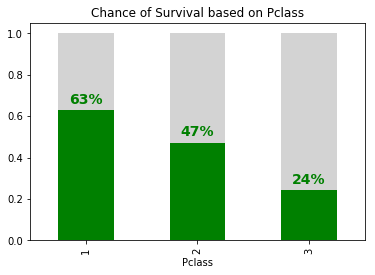

In [16]:
ax = plot_cos(data, "Pclass", figsize=(6,4))

Very clear correlation between <b><font color="blue">Title</font></b> and CoS, but not much else to do here.

#### FamilyAllSurvived & FamilyAllDied
Based on <b><font color="blue">Name</font></b>, a new set of features can be engineered to shed light on family relationships.
We are using only train data to identify families whose members either all survived or all died. It seems likely that any "new" family member that is found in the test data would share the fate.

Let's first create an auxiliary data frame that holds all the information that is needed for the new features:

In [17]:
family_info = data[data["TrainTest"]=="Train"][["Name", "Survived"]]
family_info["Name"] = family_info["Name"].apply(lambda name: name.split(",")[0])
family_counts = family_info["Name"].value_counts()
family_info = family_info.groupby("Name").sum().reset_index()
family_info["FamilyMembers"] = family_info["Name"].apply(lambda x: family_counts.loc[x])

func_all_survived = lambda row: 1 if row["Survived"]==row["FamilyMembers"] and row["FamilyMembers"]>1 else 0
family_info["FamilyAllSurvived"] = family_info.apply(func_all_survived, axis=1)

func_all_died = lambda row: 1 if row["Survived"]==0 and row["FamilyMembers"]>1 else 0
family_info["FamilyAllDied"] = family_info.apply(func_all_died, axis=1)

family_info = family_info.set_index("Name")

Now, let's map that information to the main data frame:

In [18]:
def all_survived_family(row):
    try:
        return family_info.loc[row["Name"].split(",")[0], "FamilyAllSurvived"]
    except:
        return 0
    
def all_died_family(row):
    try:
        return family_info.loc[row["Name"].split(",")[0], "FamilyAllDied"]
    except:
        return 0

data["FamilyAllSurvived"]= data.apply(all_survived_family, axis=1)
data["FamilyAllDied"]= data.apply(all_died_family, axis=1)

#### Sex

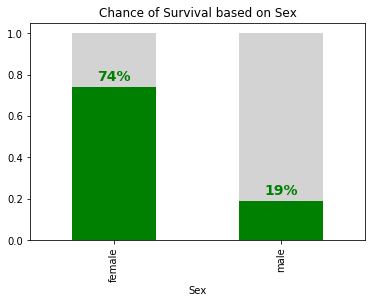

In [19]:
ax = plot_cos(data, "Sex", figsize=(6,4))

#### Title

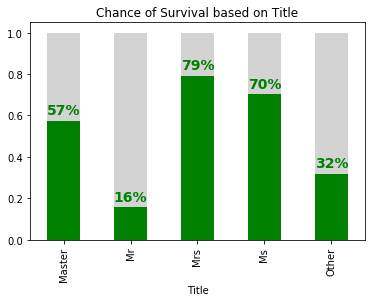

In [20]:
ax = plot_cos(data, "Title", figsize=(6,4))

#### Age
First of, <b><font color="blue">Age</font></b> will be transformed to integers:

In [21]:
data["Age"] = data["Age"].astype(int)

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Anaconda\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Anaconda\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


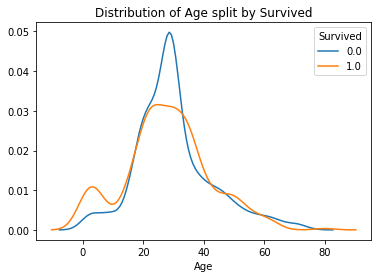

In [68]:
ax = plot_split_dist(data, column="Age", split_by="Survived")

#### AgeBin
Fixed-width binning will be used to create a new feature that should help reduce the effect of noise in the data. 

In [23]:
num_age_bins = 10
data["AgeBin"], thresholds = pd.cut(data["Age"], bins=num_age_bins, retbins=True, precision=0)

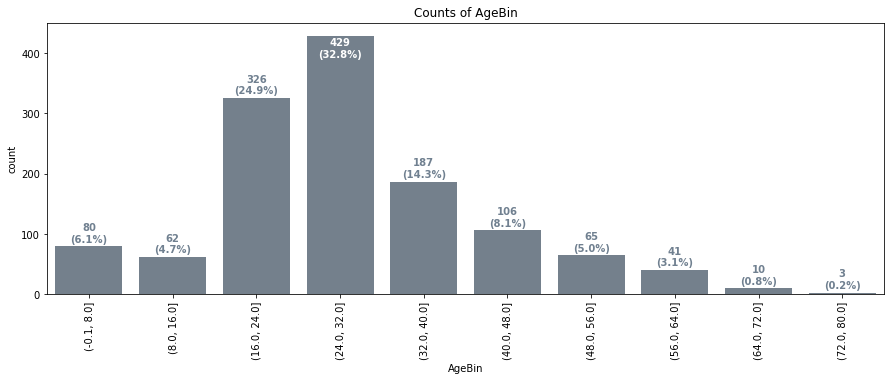

In [24]:
ax = plot_counts(data, "AgeBin", figsize=(15, 5))
plt.xticks(rotation="vertical");

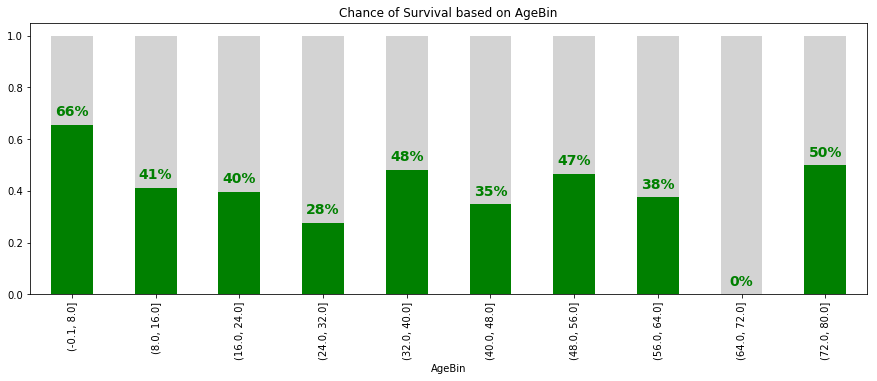

In [25]:
ax = plot_cos(data, "AgeBin", figsize=(15, 5))

Since there is no apparent linear relationship between the bins and the CoS, it's fine to use categorical bins rather than scalar ones.

#### SibSp
Denotes the number of siblings / spouses aboard the Titanic.

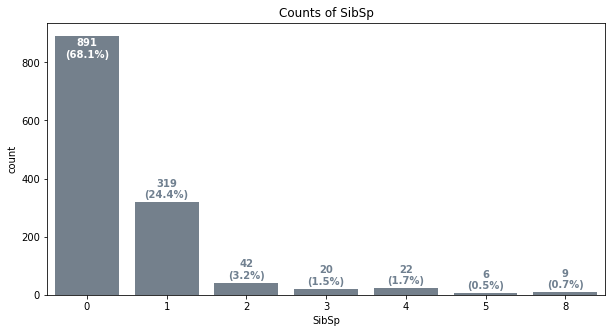

In [26]:
ax = plot_counts(data, "SibSp")

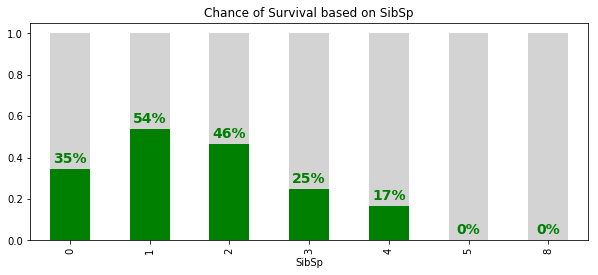

In [27]:
ax = plot_cos(data, "SibSp", figsize=(10,4))

#### Parch
Denots the number of parents / children aboard the Titanic

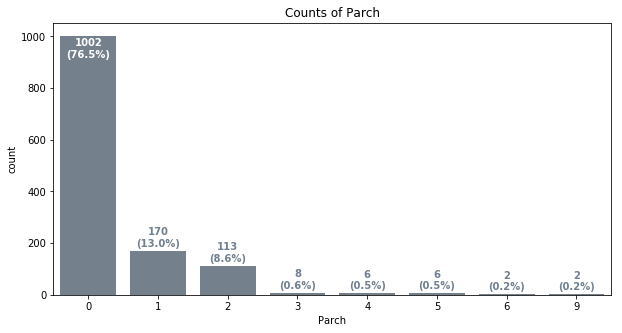

In [28]:
ax = plot_counts(data, "Parch")

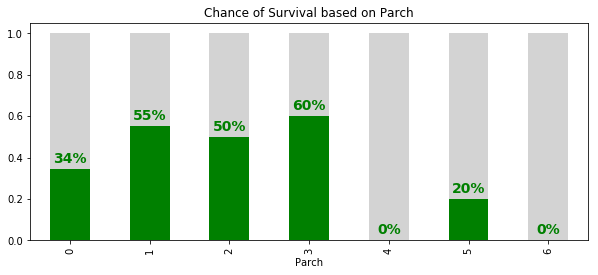

In [29]:
ax = plot_cos(data, "Parch", figsize=(10,4))

#### Fsize
Features <b><font color="blue">SibSp</font></b> and <b><font color="blue">Parch</font></b> will be combined to a new feature <b><font color="blue">Fsize</font></b> that denotes the total number of people in the family.

In [30]:
data["Fsize"] = data["SibSp"] + data["Parch"] + 1

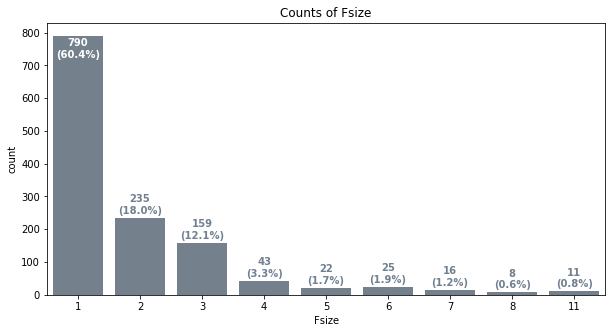

In [31]:
ax = plot_counts(data, "Fsize")

Worth noting that the majority of passengers traveled alone. To simplify this feature, families with <b><font color="blue">Fsize</font></b> > 5 will be tracked as <b><font color="blue">Fsize</font></b> = 4.

In [32]:
data["Fsize"] = data.apply(lambda row: min(row["SibSp"] + row["Parch"] + 1, 4), axis=1)

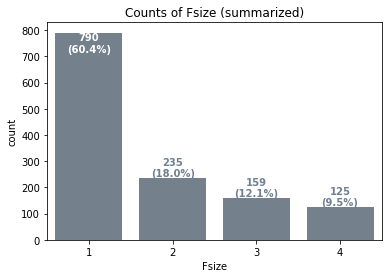

In [33]:
ax = plot_counts(data, "Fsize", figsize=(6,4))
ax.set_title("Counts of Fsize (summarized)");

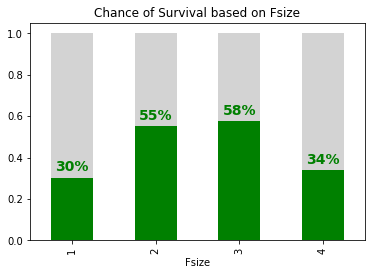

In [34]:
ax = plot_cos(data, "Fsize", figsize=(6,4))

#### Ticket

In [35]:
ticket_counts = data["Ticket"].value_counts()
ticket_counts[:5]

CA. 2343    11
CA 2144      8
1601         8
PC 17608     7
347077       7
Name: Ticket, dtype: int64

The ticket number doesn't hold any useful information, but it is interesting that some ticket numbers appear more than once.

In [36]:
num_shared_tickets = sum(data["Ticket"].value_counts() > 1)
print(f"number of shared tickets: {num_shared_tickets}")

number of shared tickets: 216


#### SharedTicket
Indicates whether a passenger shared their ticket with someone else.

In [37]:
ticket_counts = data["Ticket"].value_counts()
data["SharedTicket"] = data["Ticket"].apply(lambda x: ticket_counts.loc[x] > 1).astype(int)

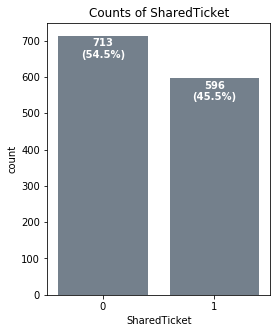

In [38]:
ax = plot_counts(data, "SharedTicket", figsize=(4,5))

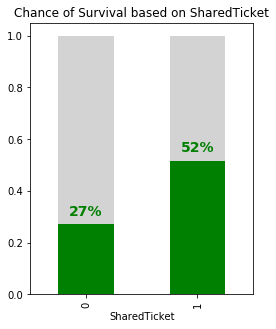

In [39]:
ax = plot_cos(data, "SharedTicket", figsize=(4,5))

#### SharedTicketAllSurvived & SharedTicketAllDied
Same principle as for the family-related features.

In [40]:
ticket_counts = data["Ticket"].value_counts()

ticket_info = data[data["TrainTest"]=="Train"][["Survived", "Ticket"]]
ticket_info = ticket_info.groupby("Ticket").sum().reset_index()
ticket_info["TicketHolders"] = ticket_info["Ticket"].apply(lambda x: ticket_counts.loc[x])

func_all_survived = lambda row: 1 if row["Survived"]==row["TicketHolders"] and row["TicketHolders"]>1 else 0
ticket_info["SharedTicketAllSurvived"] = ticket_info.apply(func_all_survived, axis=1)

func_all_died = lambda row: 1 if row["Survived"]==0 and row["TicketHolders"]>1 else 0
ticket_info["SharedTicketAllDied"] = ticket_info.apply(func_all_died, axis=1)

ticket_info = ticket_info.set_index("Ticket")
ticket_info.head()

,Survived,TicketHolders,SharedTicketAllSurvived,SharedTicketAllDied
Ticket,,,,
110152,3.0,3,1,0
110413,2.0,3,0,0
110465,0.0,2,0,1
110564,1.0,1,0,0
110813,1.0,2,0,0


In [41]:
def all_survived_ticket(ticket):
    try:
        return ticket_info.loc[ticket, "SharedTicketAllSurvived"]
    except:
        return 0

def all_died_ticket(ticket):
    try:
        return ticket_info.loc[ticket, "SharedTicketAllDied"]
    except:
        return 0
    
data["SharedTicketAllSurvived"] = data["Ticket"].apply(all_survived_ticket)
data["SharedTicketAllDied"] = data["Ticket"].apply(all_died_ticket)

#### Fare

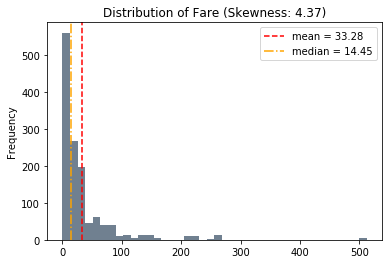

In [42]:
skew_fare = data["Fare"].skew()
ax = plot_hist(data, "Fare", bins=40)
ax.set_title(f"Distribution of Fare (Skewness: {skew_fare:.2f})");

Since <b><font color="blue">Fare</font></b> is heavily skewed, it makes sense to log-transform the feature.

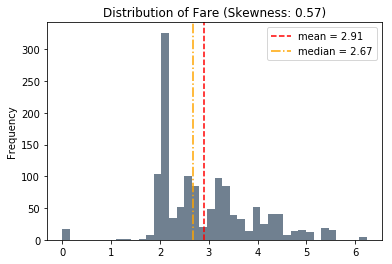

In [43]:
data["Fare"] = data["Fare"].apply(lambda x: round(np.log(x), 2) if x > 0 else 0)
skew_fare = data["Fare"].skew()
ax = plot_hist(data, "Fare", bins=40)
ax.set_title(f"Distribution of Fare (Skewness: {skew_fare:.2f})");

#### FareBin
Now, a new feature can be created similarly to <b><font color="blue">AgeBin</font></b>. This time, fixed-width bins will be used.

In [44]:
num_fare_bins = 4
data["FareBin"], fare_bins = pd.qcut(data["Fare"], q=num_fare_bins, labels=[i+1 for i in range(num_fare_bins)], retbins=True)
data["FareBin"] = data["FareBin"].astype(int)

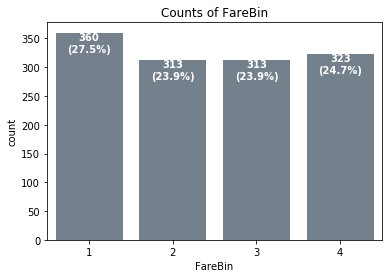

In [45]:
ax = plot_counts(data, "FareBin", figsize=(6,4))

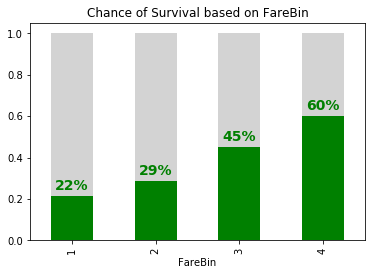

In [46]:
ax = plot_cos(data, "FareBin", figsize=(6,4))

Also, scalar bins will be used, since there is an approximate linear relationship between the bins and the CoS.

#### Cabin

In [47]:
data["Cabin"].value_counts()[:10]

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C78                4
F2                 4
B96 B98            4
F4                 4
F33                4
C22 C26            4
D                  4
Name: Cabin, dtype: int64

This feature will be dropped, but it can be used to derive new features from it ...

#### Deck
In this [discussion thread](https://www.kaggle.com/c/titanic/discussion/4693) on Kaggle, it is mentioned that the first letter of the <b><font color="blue">Cabin</font></b> denotes the deck.

In [48]:
data["Deck"] = data["Cabin"].apply(lambda x: x[:1] if not pd.isnull(x) else "None")

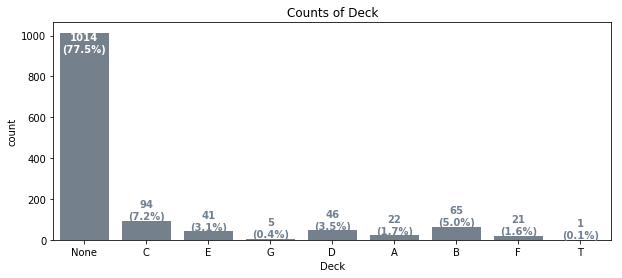

In [49]:
ax = plot_counts(data, "Deck", figsize=(10, 4))

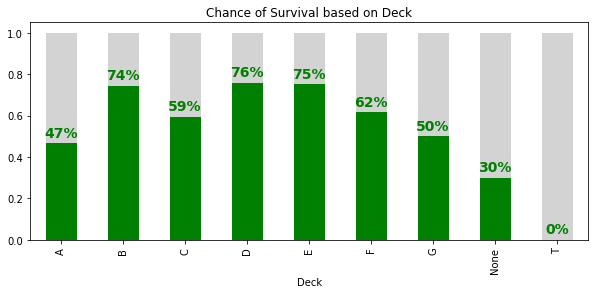

In [50]:
ax = plot_cos(data, "Deck", figsize=(10, 4))

#### NumberCabins
Some passengers have booked more than one cabin:

In [51]:
data["NumberCabins"] = data["Cabin"].apply(lambda x: len(x.split(" ")) if not pd.isnull(x) else 0)

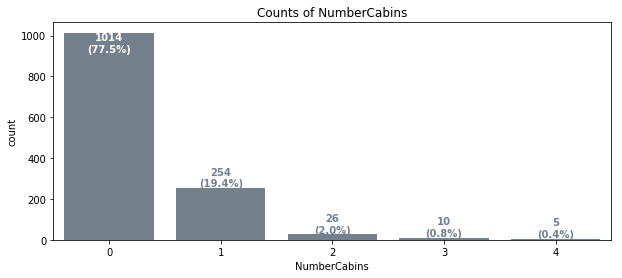

In [52]:
ax = plot_counts(data, "NumberCabins", figsize=(10, 4))

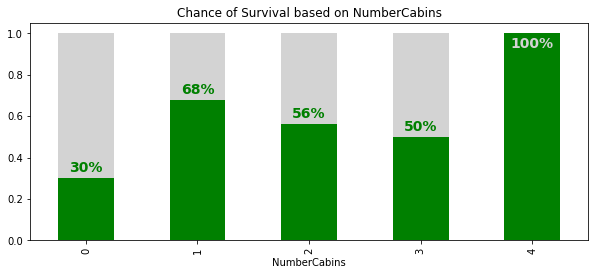

In [53]:
ax = plot_cos(data, "NumberCabins", figsize=(10, 4))

#### SharedCabin
Also, some cabins were shared by multiple passengers:

In [54]:
cabin_counts = data["Cabin"].dropna().value_counts()
cabin_counts[:5]

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C78                4
B96 B98            4
Name: Cabin, dtype: int64

In [55]:
def shared_cabin(x):
    try:
        return cabin_counts.loc[x] > 1
    except:
        return False

data["SharedCabin"] = data["Cabin"].apply(shared_cabin).astype(int)

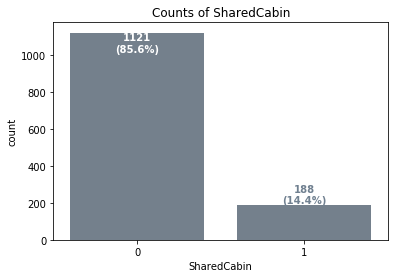

In [56]:
ax = plot_counts(data, "SharedCabin", figsize=(6,4))

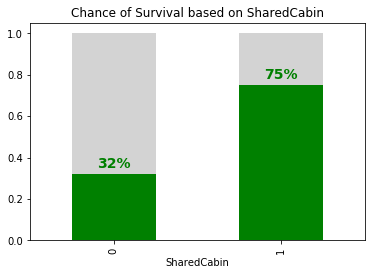

In [57]:
ax = plot_cos(data, "SharedCabin", figsize=(6,4))

#### SharedCabinAllSurvived & SharedCabinAllDied
Similar approach to the features derived from <b><font color="blue">Fsize</font></b> and <b><font color="blue">Ticket</font></b>.

In [58]:
cabin_counts = data["Cabin"].value_counts()

cabin_info = data[data["TrainTest"]=="Train"][["Survived", "Cabin"]]
cabin_info = cabin_info.groupby("Cabin").sum().reset_index()
cabin_info["CabinHolders"] = cabin_info["Cabin"].apply(lambda x: cabin_counts.loc[x])

func_all_survived = lambda row: 1 if row["Survived"]==row["CabinHolders"] and row["CabinHolders"]>1 else 0
cabin_info["SharedCabinAllSurvived"] = cabin_info.apply(func_all_survived, axis=1)

func_all_died = lambda row: 1 if row["Survived"]==0 and row["CabinHolders"]>1 else 0
cabin_info["SharedCabinAllDied"] = cabin_info.apply(func_all_died, axis=1)

cabin_info = cabin_info.set_index("Cabin")

In [59]:
def all_survived_cabin(cabin):
    try:
        return cabin_info.loc[cabin, "SharedCabinAllSurvived"]
    except:
        return 0

def all_died_cabin(cabin):
    try:
        return cabin_info.loc[cabin, "SharedCabinAllDied"]
    except:
        return 0

In [60]:
data["SharedCabinAllSurvived"] = data["Cabin"].apply(all_survived_cabin)
data["SharedCabinAllDied"] = data["Cabin"].apply(all_died_cabin)

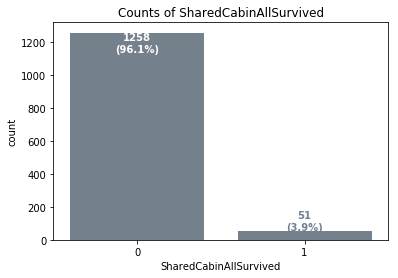

In [61]:
ax = plot_counts(data, "SharedCabinAllSurvived", figsize=(6,4))

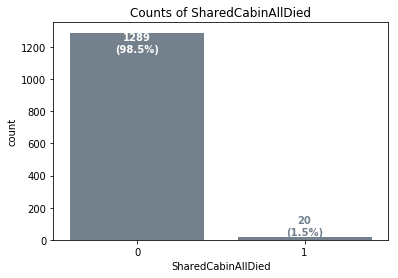

In [62]:
ax = plot_counts(data, "SharedCabinAllDied", figsize=(6,4))

### 6. Final Preparation
#### Drop unnecessary columns

In [63]:
data_opt = data.drop(labels=["Cabin", "Name", "Ticket"], axis=1)

#### Create Dummies for Categorical Data

In [64]:
data_opt = pd.get_dummies(data_opt, columns=["Sex", "Embarked", "Title", "AgeBin", "Deck"], drop_first=True)

In [65]:
data_opt.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,TrainTest,FamilyAllSurvived,FamilyAllDied,Fsize,...,"AgeBin_(64.0, 72.0]","AgeBin_(72.0, 80.0]",Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_None,Deck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,22,1,0,1.98,Train,0,1,2,...,0,0,0,0,0,0,0,0,1,0
2,1.0,1,38,1,0,4.27,Train,0,0,2,...,0,0,0,1,0,0,0,0,0,0
3,1.0,3,26,0,0,2.07,Train,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,1.0,1,35,1,0,3.97,Train,0,0,2,...,0,0,0,1,0,0,0,0,0,0
5,0.0,3,35,0,0,2.09,Train,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [66]:
data_opt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 42 columns):
Survived                   891 non-null float64
Pclass                     1309 non-null int64
Age                        1309 non-null int32
SibSp                      1309 non-null int64
Parch                      1309 non-null int64
Fare                       1309 non-null float64
TrainTest                  1309 non-null object
FamilyAllSurvived          1309 non-null int64
FamilyAllDied              1309 non-null int64
Fsize                      1309 non-null int64
SharedTicket               1309 non-null int32
SharedTicketAllSurvived    1309 non-null int64
SharedTicketAllDied        1309 non-null int64
FareBin                    1309 non-null int32
NumberCabins               1309 non-null int64
SharedCabin                1309 non-null int32
SharedCabinAllSurvived     1309 non-null int64
SharedCabinAllDied         1309 non-null int64
Sex_male                   1309 non-null ui

### 7. Data Export
The data frame is exported to a csv file so it can be loaded into a separate workbook.

In [67]:
path_output = os.path.join(os.getcwd(), data_folder, "data_prepared.csv")
data_opt.to_csv(path_output)